# ***Tensorflow implementation of Vanilla GAN***

***Import libraries & frameworks***

In [ ]:
# Import packages

import time

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.utils import plot_model

from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

***Loading the Dataset and Pre-processing***

In [ ]:
# Load MNIST Dataset
from tensorflow.keras.datasets.mnist import load_data

# Split the dataset 
(train_X,train_y), (test_X,test_y) = load_data()

# Re-shaping the array to 4D
# Values are to be float
train_X = train_X.reshape(train_X.shape[0],28,28,1).astype('float32')

# Normalizing to values between [-1,1]
train_X = (train_X - 127.5)/127.5

# Buffer & Batch Size
buffer_size = 60000
batch_size = 256

# Shuffle & obtain Final Dataset
td = tf.data.Dataset.from_tensor_slices(train_X).shuffle(buffer_size).batch(batch_size)

11501568/11490434 [==============================] - 0s 0us/step


***Generator***

In [ ]:
# Generator

def Generator():

  model = Sequential()

  model.add(layers.Input(shape = (100,)))
  model.add(layers.Dense(128, kernel_initializer=tf.keras.initializers.he_uniform))
  model.add(layers.LeakyReLU(0.2))

  model.add(layers.Dense(256, kernel_initializer=tf.keras.initializers.he_uniform))
  model.add(layers.BatchNormalization(momentum=0.1,  epsilon=0.8))
  model.add(layers.LeakyReLU(0.2))

  model.add(layers.Dense(512, kernel_initializer=tf.keras.initializers.he_uniform))
  model.add(layers.BatchNormalization(momentum=0.1,  epsilon=0.8))
  model.add(layers.LeakyReLU(0.2))

  model.add(layers.Dense(1024, kernel_initializer=tf.keras.initializers.he_uniform))
  model.add(layers.BatchNormalization(momentum=0.1,  epsilon=0.8))
  model.add(layers.LeakyReLU(0.2))

  model.add(layers.Dense(28*28*1, activation='tanh', kernel_initializer=tf.keras.initializers.he_uniform))

  model.add(layers.Reshape((28,28,1)))

  plot_model(model,"generator.png")
  model.summary()
  return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               12928     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                        

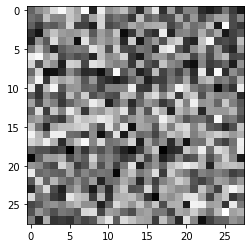

In [ ]:
# sample image generated by the the generator
generator = Generator()

noise = tf.random.normal([1, 100]) #latent space
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

***Discriminator***

In [ ]:
def Discriminator():

    model = Sequential()

    model.add(layers.Input(shape=(28,28,1)))

    model.add(layers.Reshape((-1, 784)))
    
    model.add(layers.Dense(512, kernel_initializer=tf.keras.initializers.he_uniform))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Dense(256, kernel_initializer=tf.keras.initializers.he_uniform))
    model.add(layers.LeakyReLU(0.2))

    model.add(Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.he_uniform)) 
    
    model.summary()
    plot_model(model,"discriminator.png")
    return model

In [ ]:
discriminator = Discriminator()
classify = discriminator(generated_image)
print (classify)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 1, 784)            0         
                                                                 
 dense_5 (Dense)             (None, 1, 512)            401920    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 1, 512)            0         
                                                                 
 dense_6 (Dense)             (None, 1, 256)            131328    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 1, 256)            0         
                                                                 
 dense_7 (Dense)             (None, 1, 1)              257       
                                                                 
Total params: 533,505
Trainable params: 533,505
Non-tr

***Loss function & Optimizers***

In [ ]:
adversarial_loss = tf.keras.losses.BinaryCrossentropy()

In [ ]:
# Generator loss

def generator_loss(fake_output):
    gen_loss = adversarial_loss(tf.ones_like(fake_output), fake_output)
    #print(gen_loss)
    return gen_loss

In [ ]:
# Discriminator loss

def discriminator_loss(real_output, fake_output):
    real_loss = adversarial_loss(tf.ones_like(real_output), real_output)
    fake_loss = adversarial_loss(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
# Optimizers

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

***Training***

In [ ]:
epochs = 200 #maximum number of iterations
noise_dim = 100
num_output = 16
seed = tf.random.normal([num_output, noise_dim])

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training = True)

      real_output = discriminator(images, training = True)
      fake_output = discriminator(generated_images, training = True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    display_gen_image(generator,epoch+1,seed)

    print ('Time for epoch {} is {} seconds'.format(epoch + 1, time.time()-start))

  # Final epoch
  display.clear_output(wait=True)
  display_gen_image(generator,epoch,seed)

***Display Generated Images***

In [ ]:
def display_gen_image(model,epoch,test_input):

  # Training is set 'False', so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.show()

***Output***

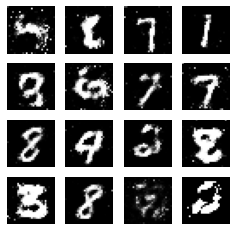

In [ ]:
train(td, epochs)